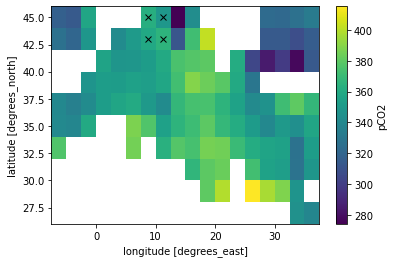

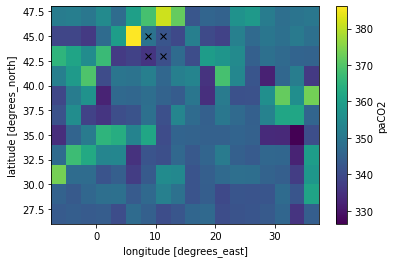

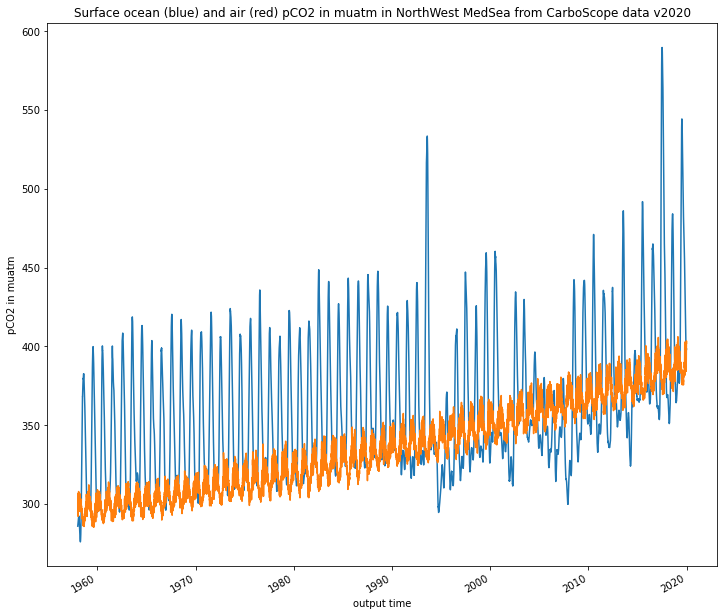

In [1]:
#from dask.distributed import Client, LocalCluster

#cluster = LocalCluster(processes=False, threads_per_worker=4)
#client = Client(cluster)
#client

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import nc_time_axis
import cftime
import time
import os
#import cmocean as cm
import matplotlib as mpl
import dask
import netCDF4 
from netCDF4 import Dataset as ncread
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.interpolate import interp1d
import datetime as dt
import pandas as pd


datapath = '/media/simon/Seagate Backup Plus Drive/theoceanrace/DATA/TORE/CARBOSCOPE/'
pCO2 = xr.open_dataset(datapath + 'oc_v2020_pCO2_daily.nc')
paCO2 = xr.open_dataset(datapath + 'oc_v2020_paCO2_daily.nc')

lat_min = 66
lat_max = 67
lon_min = 75
lon_max = 76

# paCO2 is given in muatm
mean_pCO2 = pCO2.pCO2.where(pCO2.pCO2 > 1).mean(dim='mtime')
mean_pCO2[58:68,69:87].plot()

plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_max],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_max],'xk')
plt.show()

# paCO2 is given in mbar
factor_mbar_to_muatm = 1e3/1.01325
tmean_paCO2_muatm = paCO2.paCO2.mean(dim='mtime')*factor_mbar_to_muatm
tmean_paCO2_muatm[58:69,69:87].plot()

plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_max],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_max],'xk')
plt.ion()
plt.show()

spatial_mean_pCO2_muatm = pCO2.pCO2[:,lat_min:lat_max,lon_min:lon_max].where(pCO2.pCO2 > 1).mean(dim='lon').mean(dim='lat').sel(mtime=slice("1958-01-01", "2019-12-31"))
spatial_mean_paCO2_muatm = paCO2.paCO2[:,lat_min:lat_max,lon_min:lon_max].mean(dim='lon').mean(dim='lat').sel(mtime=slice("1958-01-01", "2019-12-31"))*factor_mbar_to_muatm

plt.figure(figsize=(12, 10))
spatial_mean_pCO2_muatm.plot()
spatial_mean_paCO2_muatm.plot()
plt.title('Surface ocean (blue) and air (red) pCO2 in muatm in NorthWest MedSea from CarboScope data v2020')
plt.ylabel('pCO2 in muatm')
plt.ion()
plt.show()

In [8]:
# Now add TORE data
output_file_ambersail = '/media/simon/Seagate Backup Plus Drive/theoceanrace/DATA/TORE/210620DATA0_AmberSail_ALL/Analysis_TORE_FULL_AmberSail/SCT_DATA_TORE_FULL_QC_CLEANED_nonan.csv'
output_file_11thHour  = '/media/simon/Seagate Backup Plus Drive/theoceanrace/DATA/TORE/210612DATA0_Leg1_2_3_11thHour/Analysis_TORE_leg1_2_3_11thHour/SCT_DATA_TORE_leg1_2_3_QC_CLEANED1_nonan.csv'
# output_file_akzo = '/media/simon/Seagate Backup Plus Drive/theoceanrace/DATA/TORE/210528DATA0_AKZONOBEL/Analysis_TORE_FULL_AKZO/SCT_DATA_TORE_FULL_QC_CLEANED_nonans.csv'
df_AB = pd.read_csv(output_file_ambersail,skiprows=0)
df_11 = pd.read_csv(output_file_11thHour,skiprows=0)
df_combined = df_AB.append(df_11)

# find data within the same cells considered in Carboscope
frame = [pCO2.lon_bounds[lon_min][0],pCO2.lon_bounds[lon_max][1],pCO2.lat_bounds[lat_min][0],pCO2.lat_bounds[lat_max][1]]
poly = np.zeros((5,2))
poly[0,:] = [pCO2.lon_bounds[lon_min][0],pCO2.lat_bounds[lat_min][0]]
poly[1,:] = [pCO2.lon_bounds[lon_max][1],pCO2.lat_bounds[lat_min][0]]
poly[2,:] = [pCO2.lon_bounds[lon_max][1],pCO2.lat_bounds[lat_max][1]]
poly[3,:] = [pCO2.lon_bounds[lon_min][0],pCO2.lat_bounds[lat_max][1]]
poly[4,:] = poly[0,:]

In [6]:
# average pC02 data within the polygon
pCO2_TORE_frame = df_combined.loc[(df_combined['longitude'] >= pCO2.lon_bounds[lon_min][0].data) &
                                  (df_combined['longitude'] <= pCO2.lon_bounds[lon_max][1].data) &
                                  (df_combined['latitude'] >= pCO2.lat_bounds[lat_min][0].data) &
                                  (df_combined['latitude'] <= pCO2.lat_bounds[lat_max][1].data) & 
                                  (df_combined['pCO2_muatm'] > 0)]

pCO2_TORE_frame['datetime64'] = pd.to_datetime(dict(year=pCO2_TORE_frame.year, 
                                                month=pCO2_TORE_frame.month, 
                                                day=pCO2_TORE_frame.day,
                                                hour=pCO2_TORE_frame.hour,
                                                minute=pCO2_TORE_frame.minute))

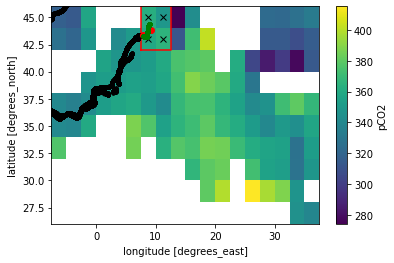

In [7]:
# Map showing positions of carboscope cells and selected TORE tracks
mean_pCO2[58:68,69:87].plot()
plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_min],'xk')
plt.plot(pCO2.lon[lon_min],pCO2.lat[lat_max],'xk')
plt.plot(pCO2.lon[lon_max],pCO2.lat[lat_max],'xk')
plt.plot(poly[:,0],poly[:,1],'r')
plt.plot(df_combined['longitude'],df_combined['latitude'],'k.')
plt.plot(7.900705000000000,43.367003333333340,'ro') #DYFAMED
plt.plot(9.160000000000000,43.790000000000000,'ro') #W1M3A
# check the selection correct
plt.plot(pCO2_TORE_frame['longitude'],pCO2_TORE_frame['latitude'],'g.')

Text(0, 0.5, 'pCO2 in muatm')

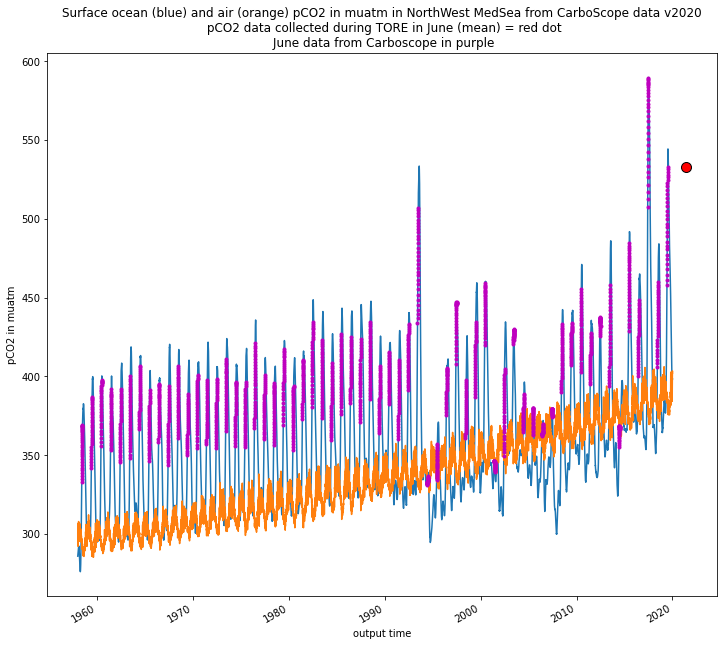

In [9]:
# now plot the mean of pCO2 measured during TORE, within cells, over the historical graph
plt.figure(figsize=(12, 10))
spatial_mean_pCO2_muatm.plot()
spatial_mean_paCO2_muatm.plot()
# add TORE data 
plt.plot(pCO2_TORE_frame['datetime64'].mean(),pCO2_TORE_frame['pCO2_muatm'].mean(),'r.', markersize=20, markeredgecolor='k')
# Highlight carboscope data from same month of June for comparison
spatial_mean_pCO2_muatm[spatial_mean_pCO2_muatm.mtime.dt.month==6].plot.line('.',c='m')
plt.title('Surface ocean (blue) and air (orange) pCO2 in muatm in NorthWest MedSea from CarboScope data v2020' + 
         '\n pCO2 data collected during TORE in June (mean) = red dot' +  
         '\n June data from Carboscope in purple' )
plt.ylabel('pCO2 in muatm')

(9156.0, 18962.0)

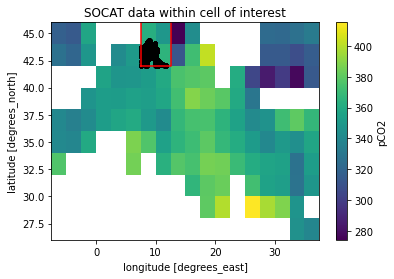

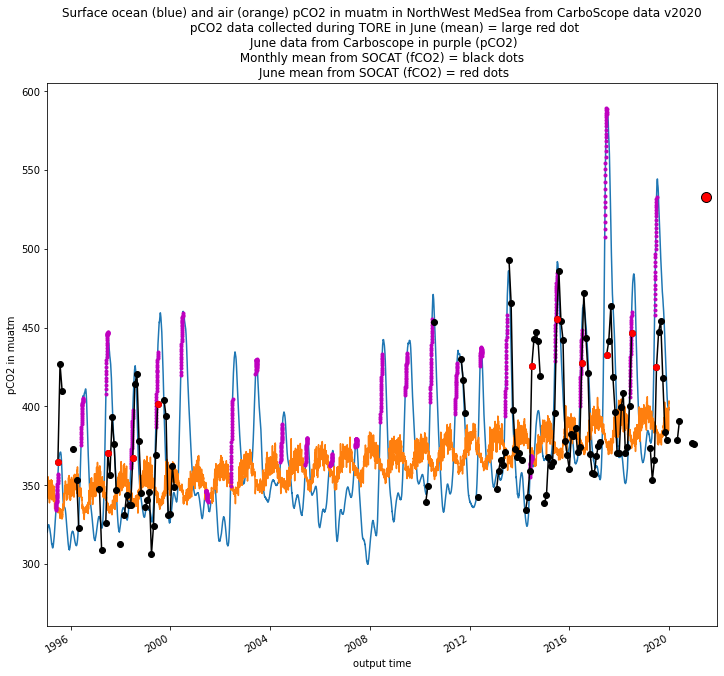

In [10]:
# Adding SOCAT data for comparison 
# download URL (raw track/buoy data within NW MedSea):
# https://data.pmel.noaa.gov/socat/las/UI.vm#panelHeaderHidden=false;differences=false;autoContour=false;xCATID=SOCATv2021_ERDDAP;xDSID=socat_v2021_fulldata;varid=fCO2_recommended-socat_v2021_fulldata;imageSize=auto;over=xy;compute=None;constraintCount=2;constraint0=text_cr_none_cr_none_cr_WOCE_CO2_water_cr_2_cr_WOCE_CO2_water_cr_2_cr_eq_cr_;constraint1=variable_cr_socat_v2021_fulldata_cr_fCO2_recommended-socat_v2021_fulldata_cr_fCO2_recommended_cr_NaN_cr_fCO2_recommended_cr_NaN_cr_ne_cr_;constraintPanelIndex=0token;catid=SOCATv2021_ERDDAP;dsid=socat_v2021_fulldata;varid=fCO2_recommended-socat_v2021_fulldata;avarcount=0;xlo=-1.0546875;xhi=14.0625;ylo=36.5625;yhi=45.3515625;tlo=01-Jan-1993%2000:00;thi=31-Dec-2020%2000:00;operation_id=Trajectory_interactive_plot;view=xyt
socat = xr.open_dataset(datapath + 'SOCAT_netcdf_fCO2.nc')
# subset the xarray dataset to keep relevant data in our frame of interest
socat_TORE_frame = socat.where((socat.longitude >= pCO2.lon_bounds[lon_min][0].data) &
                               (socat.longitude <= pCO2.lon_bounds[lon_max][1].data) &
                               (socat.latitude >= pCO2.lat_bounds[lat_min][0].data) &
                               (socat.latitude <= pCO2.lat_bounds[lat_max][1].data),
                               drop=True)
# do we need to filter for depth of measurement as well ? 
# depth range of SOCAT measurments is 0.5 to 5.0m below sea surface (bss)..most at 5.0m bss

# check plot for SOCAT data location
mean_pCO2[58:68,69:87].plot()
plt.plot(socat_TORE_frame.longitude,socat_TORE_frame.latitude,'k.') # to check extents
plt.plot(poly[:,0],poly[:,1],'r')
plt.title('SOCAT data within cell of interest')

# declare a new data array with correct time dimension so we can use xarray functionalities
data = xr.DataArray(
       socat_TORE_frame.fCO2_recommended.data,
       coords={"time": socat_TORE_frame.time.data,},
        dims=["time"],
       )
data = data.sortby(data.time, ascending=True) # reorder dates
# make monthly average
data_monthly = data.resample(time='m').mean()
# find all months of june, as when TORE data was collected
data_june = data_monthly.sel(time=data_monthly.time.dt.month.isin([6]))

# Combined plot with Carboscope, TORE, Socat data 
plt.figure(figsize=(12, 10))
# Carboscope
spatial_mean_pCO2_muatm.plot()
spatial_mean_paCO2_muatm.plot()
# Highlight carboscope data June, same month as TORE data
spatial_mean_pCO2_muatm[spatial_mean_pCO2_muatm.mtime.dt.month==6].plot.line('.',c='m')
# add TORE data 
plt.plot(pCO2_TORE_frame['datetime64'].mean(),pCO2_TORE_frame['pCO2_muatm'].mean(),'r.', markersize=20, markeredgecolor='k')
# add SOCAT data for area of interest
# plt.plot(socat_TORE_frame.time,socat_TORE_frame.fCO2_recommended,'r.') # full dataset
plt.plot(data_monthly.time,data_monthly.data,'k') # monthly mean 
plt.plot(data_monthly.time,data_monthly.data,'ko') # monthly mean 
plt.plot(data_june.time,data_june.data,'ro',markeredgecolor='r')

plt.title('Surface ocean (blue) and air (orange) pCO2 in muatm in NorthWest MedSea from CarboScope data v2020' + 
         '\n pCO2 data collected during TORE in June (mean) = large red dot' +  
         '\n June data from Carboscope in purple (pCO2)' + 
         '\n Monthly mean from SOCAT (fCO2) = black dots ' + 
         '\n June mean from SOCAT (fCO2) = red dots')
plt.ylabel('pCO2 in muatm')
plt.xlim([dt.date(1995, 1, 26), dt.date(2021, 12, 1)])